In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
from torchsummary import summary

print(torch.__version__)

1.11.0+cu113


In [ ]:
# Hyper-parameters
learning_rate = 0.001
n_epochs = 10
batch_size = 100
n_classes = 10
random_seed = 777

In [ ]:
# For Reproducibilty
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [ ]:
# Data 불러오기
data_dir = './data'

train_data = datasets.CIFAR10(
    root=data_dir,
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

val_data = datasets.CIFAR10(
    root=data_dir,
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
val_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
label_list = train_data.classes
label_list

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

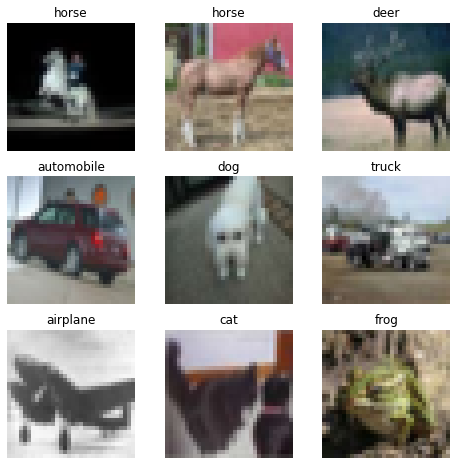

In [ ]:
# Data Visualization
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    img = img.permute(1,2,0)
    figure.add_subplot(rows, cols, i)
    plt.title(label_list[label])
    plt.axis("off")
    plt.imshow(img)
plt.show()

In [ ]:
# DataLoader 만들기
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

Feature batch shape: torch.Size([100, 3, 32, 32])
Labels batch shape: torch.Size([100])


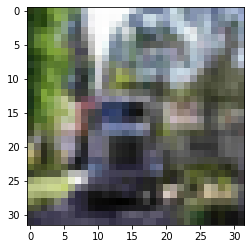

Label: truck(9)


In [ ]:
# DataLoader를 통해 반복하기(iterate)
# 이미지와 정답(label)을 표시합니다.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].permute(1,2,0)
label = train_labels[0]
label_name = label_list[label]
plt.imshow(img)
plt.show()
print(f"Label: {label_name}({label})")

In [ ]:
# device 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [ ]:
# CNN Model 만들기
class VanillaCNN(nn.Module):
  def __init__(self):
    super(VanillaCNN, self).__init__()
    self.conv1 = nn.Sequential(nn.Conv2d(3, 32, 3, padding=1),
                               nn.ReLU(),
                               nn.MaxPool2d(2,2))
    self.conv2 = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1),
                               nn.ReLU(),
                               nn.MaxPool2d(2,2))
    self.conv3 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1),
                               nn.ReLU(),
                               nn.MaxPool2d(2,2))
    self.fc1 = nn.Sequential(nn.Linear(4*4*128, 256),
                             nn.ReLU(),
                             nn.Dropout(0.4))
    self.fc2 = nn.Sequential(nn.Linear(256, 10))

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(-1, 4*4*128)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

In [ ]:
# Model instance 생성, device 설정
model = VanillaCNN().to(device)

In [ ]:
print(model)

VanillaCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=2048, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [ ]:
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
              ReLU-8            [-1, 128, 8, 8]               0
         MaxPool2d-9            [-1, 128, 4, 4]               0
           Linear-10                  [-1, 256]         524,544
             ReLU-11                  [-1, 256]               0
          Dropout-12                  [-1, 256]               0
           Linear-13                   [-1, 10]           2,570
Total params: 620,362
Trainable params:

In [ ]:
# Loss Function
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Optimizer
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)

In [ ]:
# Train Function
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  n_batches = len(dataloader)
  model.train()
  train_loss = 0.
  for batch, (data, label) in enumerate(dataloader):
    data, label = data.to(device), label.to(device)
    pred = model(data)
    loss = loss_fn(pred, label)    

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
  train_loss /= n_batches

  print(f"Training Loss: {train_loss:>8f}")

In [ ]:
# Validation Function
def val_loop(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  n_batches = len(dataloader)
  model.eval()
  val_loss, correct = 0., 0
  with torch.no_grad():
    for data, label in dataloader:
      data, label = data.to(device), label.to(device)
      pred = model(data)
      val_loss += loss_fn(pred, label).item()
      correct += (pred.argmax(1) == label).type(torch.float).sum().item()
  val_loss /= n_batches
  correct /= size
  print(f"Validation Loss: {val_loss:>8f} Validation Accuracy: {(100*correct):>0.4f}%, \n")

In [ ]:
# 학습 진행하기
for epoch in range(n_epochs):
  print(f"<<Epoch {epoch+1}>>\n------------------------------------------------")
  train_loop(train_dataloader, model, loss_fn, optimizer)
  val_loop(val_dataloader, model, loss_fn)
print("Training Done!")

<<Epoch 1>>
------------------------------------------------
Training Loss: 1.651886
Validation Loss: 1.312094 Validation Accuracy: 52.1200%, 

<<Epoch 2>>
------------------------------------------------
Training Loss: 1.272587
Validation Loss: 1.115789 Validation Accuracy: 60.5200%, 

<<Epoch 3>>
------------------------------------------------
Training Loss: 1.116269
Validation Loss: 1.010954 Validation Accuracy: 63.6200%, 

<<Epoch 4>>
------------------------------------------------
Training Loss: 0.993267
Validation Loss: 0.932364 Validation Accuracy: 66.6500%, 

<<Epoch 5>>
------------------------------------------------
Training Loss: 0.910260
Validation Loss: 0.873615 Validation Accuracy: 69.1500%, 

<<Epoch 6>>
------------------------------------------------
Training Loss: 0.844753
Validation Loss: 0.845349 Validation Accuracy: 70.5000%, 

<<Epoch 7>>
------------------------------------------------
Training Loss: 0.785706
Validation Loss: 0.818326 Validation Accuracy: 71.6